In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ml import KramersMoyal,load_kernels_dict
from plot import ImperialColors
from potenciala import BucketMethod, VectorTimeSeries


In [3]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [4]:
df = df_raw.query("year >= 2004 & year <= 2020")

### Load multivariate time series for frequentist approach

In [5]:
s = VectorTimeSeries(df=df, 
                     signal_name="spain", 
                     bucket_method=BucketMethod.Round, 
                     bin_size=1, 
                     diff_matrix_xi_xj_computation=False)

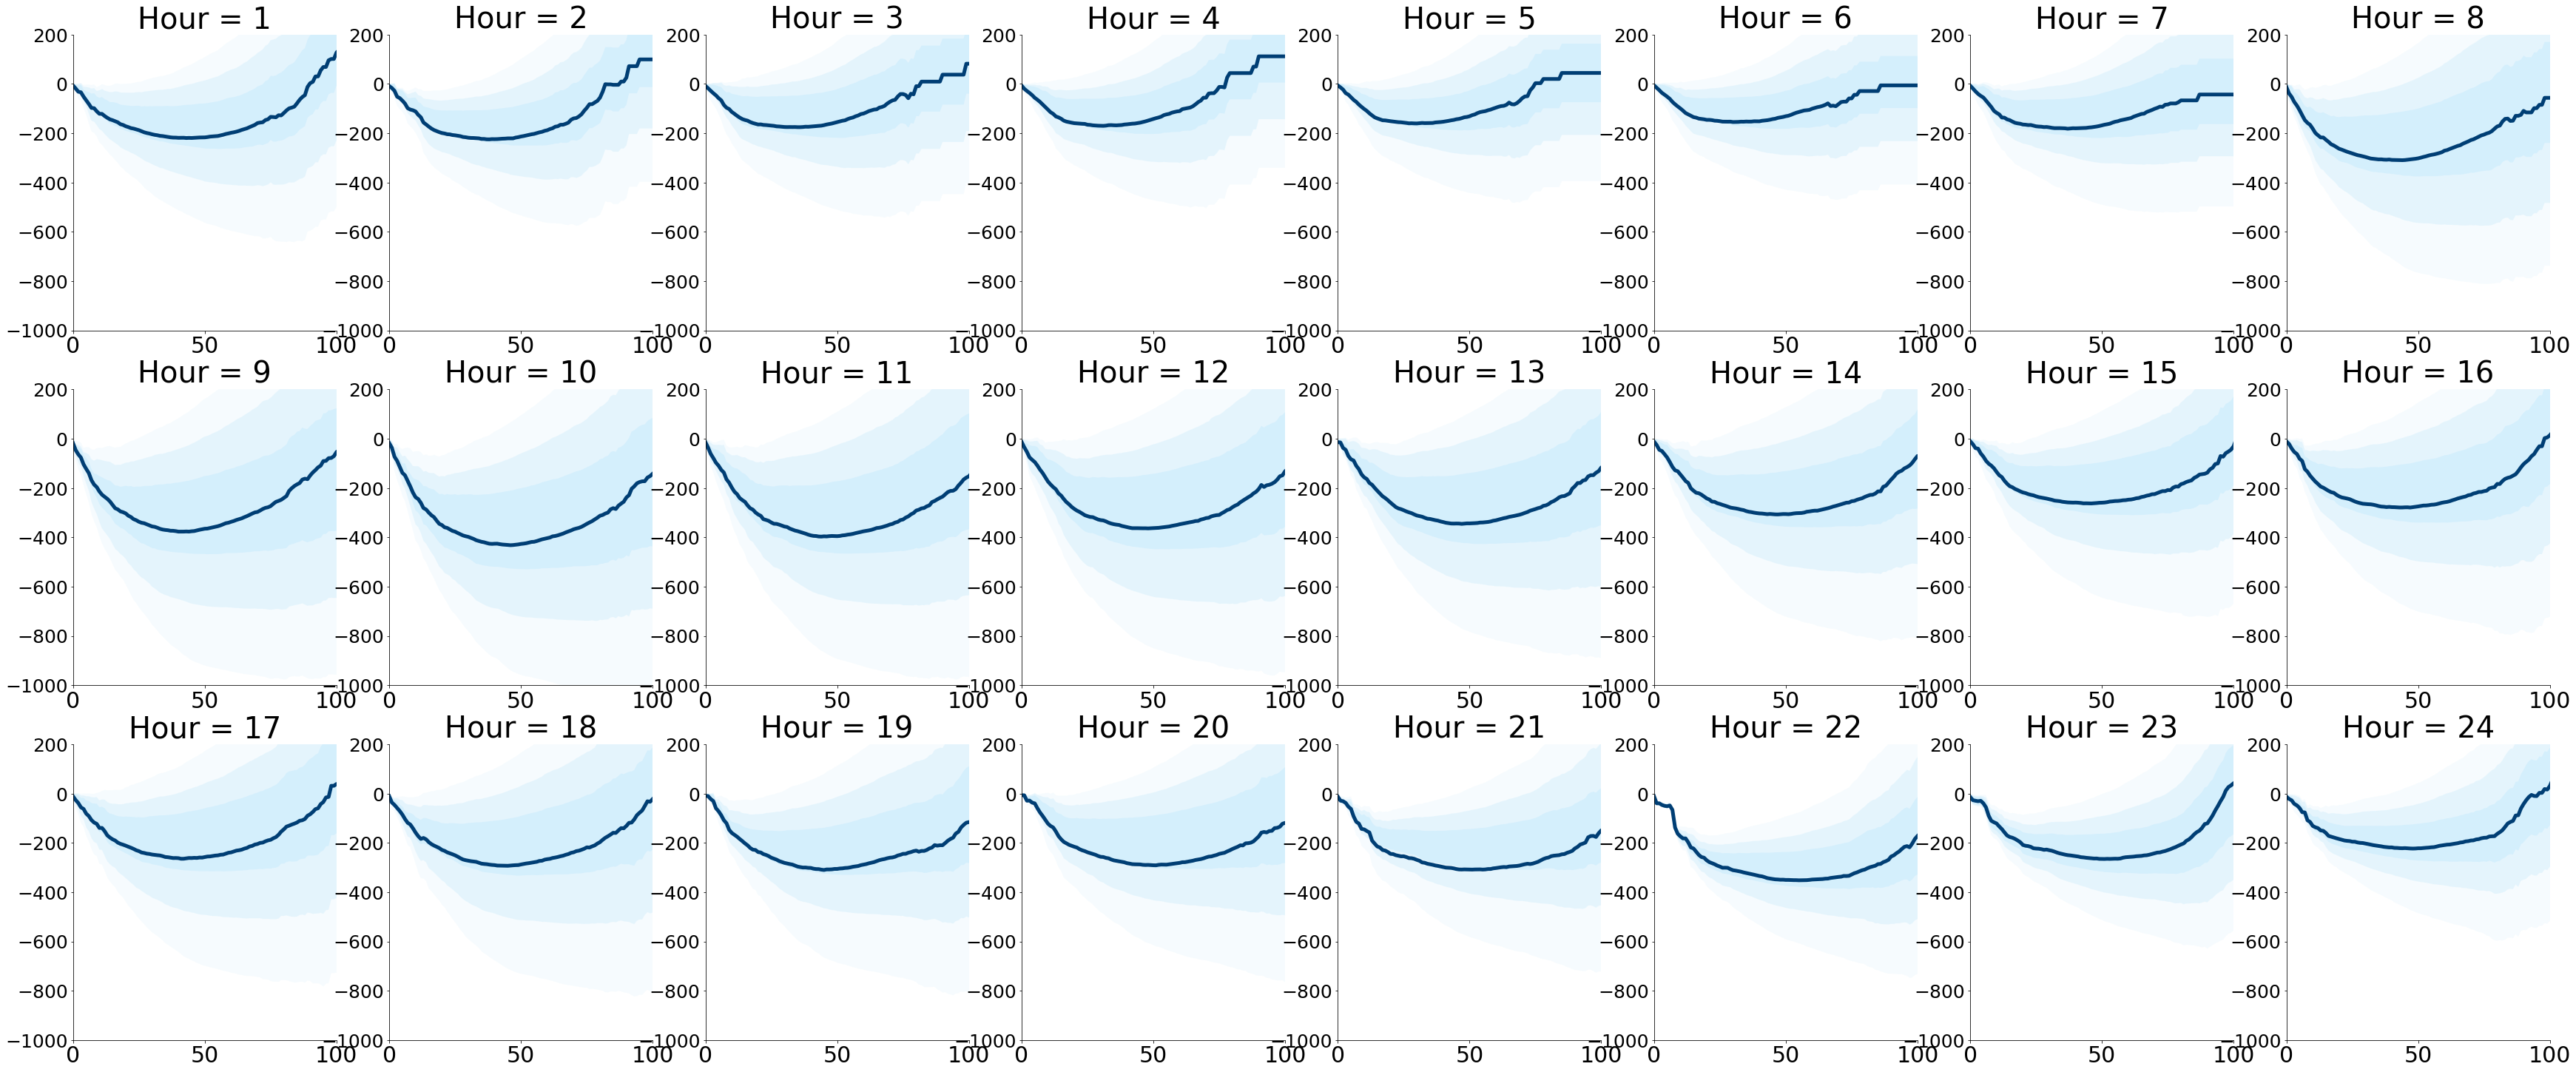

In [6]:
fig, axis = plt.subplots(3, 8, figsize=(60, 25))
percentiles_alpha = [0.2, 0.5, 1]

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*8+j
        s.potential_hour_x.loc[h].plot(ax=ax, lw=5, color=ImperialColors.blue.value)
        for k, alpha_value in enumerate(percentiles_alpha):            
            ax.fill_between(
                    s.potential_percentile_hour_x.columns, 
                    s.potential_percentile_hour_x.loc[h, s.drift_quantile[k]], 
                    s.potential_percentile_hour_x.loc[h, s.drift_quantile[-k-1]],
                    facecolor=ImperialColors.light_blue.value, alpha=alpha_value)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=40)
        ax.set_xlim(0, 100)
        ax.set_ylim(-1000, 200)
        ax.tick_params(axis='x', labelsize=30)
        ax.tick_params(axis='y', labelsize=25)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

### Load multivariate series and KDE technique to compute drift and potential percentile

In [7]:
s_kde = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.NoBucket)

d_1_dict = load_kernels_dict(path="data/kde/d_1/", pattern="d_1_(.*)_1000_1000", dim_num=1)

<AxesSubplot:>

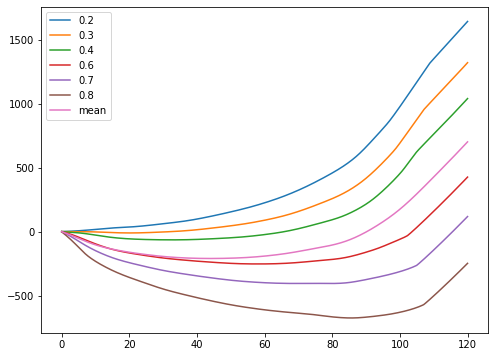

In [8]:
x_range = d_1_dict[1].grid[0][:, 0]
perc_list = [0.2, 0.3, 0.4, 0.6, 0.7, 0.8]
hours_list = np.arange(1, 25)
multi_idx = pd.MultiIndex.from_product([hours_list, perc_list + ["mean"]])
drift_percentile_value_x = pd.DataFrame(index=multi_idx, columns=x_range)

for h in hours_list:
    gk = d_1_dict[h]
    for perc in perc_list:
        drift_percentile_value_x.loc[(h, perc), x_range] = np.zeros_like(x_range)
        percentile_value = np.zeros_like(x_range)
        for i in range(x_range.shape[0]):
            first_index = np.where((np.cumsum(gk.p[i]) / sum(gk.p[i])) > perc)[0][0]
            percentile_value[i] = gk.grid[1][i][first_index]
        drift_percentile_value_x.loc[(h, perc)] = percentile_value

    drift_percentile_value_x.loc[(h,"mean")] = gk.expected_value_function[1, :]

# Integrate to compute potential
dx = gk.expected_value_function[0, 1] - gk.expected_value_function[0, 0]

((-1)*np.cumsum(drift_percentile_value_x.loc[1] * dx, axis=1)).T.plot()

<AxesSubplot:>

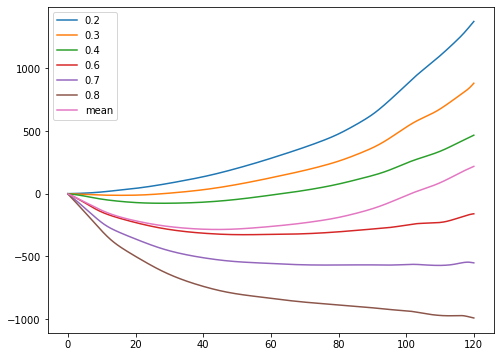

In [9]:
((-1)*np.cumsum(drift_percentile_value_x.loc[18] * dx, axis=1)).T.plot()

In [10]:
drift_percentile_value_x

0.000000   0.120120   0.240240   0.360360   0.480480   0.600601    \
1  0.2   -0.661562  -0.661562  -0.661562  -0.800871  -0.800871  -0.800871   
   0.3    0.592222   0.452913   0.452913   0.452913   0.452913   0.452913   
   0.4    1.846006   1.846006   1.846006   1.846006   1.846006   1.846006   
   0.6    6.582523   6.582523   6.721832   6.721832   6.861141   6.861141   
   0.7   12.154895  12.294204  12.433514  12.433514  12.572823  12.712132   
...            ...        ...        ...        ...        ...        ...   
24 0.4    3.717047   3.717047   3.717047   3.717047   3.717047   3.717047   
   0.6   13.550651  13.550651  13.550651  13.451321  13.451321  13.451321   
   0.7     18.1198    18.1198    18.1198    18.1198    18.1198    18.1198   
   0.8   24.973524  24.874194  24.874194  24.874194  24.874194  24.874194   
   mean  11.330288  11.309787  11.289766  11.270244  11.251239   11.23277   

        0.720721   0.840841   0.960961   1.081081    ... 118.918919  \
1  0.2   -0.800871  -0.800871   -0.94018   -0.94018  ... -29.637898   
   0.3    0.452913   0.452913   0.313604   0.313604  ... -28.941351   
   0.4    1.846006   1.846006   1.846006   1.846006  ... -28.384114   
   0.6     7.00045    7.13976    7.13976   7.279069  ... -27.408949   
   0.7   12.851441  12.990751   13.13006  13.269369  ... -26.851712   
...            ...        ...        ...        ...  ...        ...   
24 0.4    3.717047   3.717047   3.717047   3.717047  ... -21.413273   
   0.6   13.351992  13.351992  13.351992  13.252663  ... -20.519309   
   0.7     18.1198    18.1198    18.1198    18.1198  ... -20.022663   
   0.8   24.874194  24.774865  24.774865  24.774865  ... -19.426687   
   mean  11.214854  11.197508  11.180747  11.164586  ... -20.707296   

        119.039039 119.159159 119.279279 119.399399 119.519520 119.639640  \
1  0.2  -29.637898 -29.637898 -29.637898 -29.777207 -29.777207 -29.777207   
   0.3  -28.941351 -29.080661 -29.080661 -29.080661 -29.080661 -29.080661   
   0.4  -28.384114 -28.523423 -28.523423 -28.523423 -28.523423 -28.523423   
   0.6  -27.408949 -27.408949 -27.408949 -27.548258 -27.548258 -27.548258   
   0.7  -26.851712 -26.851712 -26.991021 -26.991021 -26.991021 -26.991021   
...            ...        ...        ...        ...        ...        ...   
24 0.4  -21.413273 -21.413273 -21.512603 -21.512603 -21.512603 -21.512603   
   0.6  -20.519309 -20.519309 -20.519309 -20.618639 -20.618639 -20.618639   
   0.7  -20.022663 -20.022663 -20.022663 -20.121992 -20.121992 -20.121992   
   0.8  -19.426687 -19.426687 -19.526016 -19.526016 -19.526016 -19.526016   
   mean -20.736519  -20.76533 -20.793743 -20.821769 -20.849424  -20.87672   

        119.759760 119.879880 120.000000  
1  0.2  -29.777207 -29.777207 -29.777207  
   0.3  -29.080661  -29.21997  -29.21997  
   0.4  -28.523423 -28.662733 -28.662733  
   0.6  -27.548258 -27.548258 -27.548258  
   0.7  -26.991021 -26.991021  -27.13033  
...            ...        ...        ...  
24 0.4  -21.512603 -21.611932 -21.611932  
   0.6  -20.618639 -20.618639 -20.717968  
   0.7  -20.121992 -20.221321 -20.221321  
   0.8  -19.526016 -19.625345 -19.625345  
   mean -20.903669 -20.930282 -20.956573  

[168 rows x 1000 columns]